# Train Model

In [1]:
# https://maharshi-yeluri.medium.com/understanding-and-implementing-speech-recognition-using-hmm-6a4e7666de1


import os
import numpy as np
from scipy.io import wavfile
from hmmlearn import hmm
import librosa
from librosa.feature import mfcc
import pandas as pd

class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []

        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components, 
                    covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    # X is a 2D numpy array where each row is 13D
    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))

    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)
    
# training

hmm_models = []

X_dict = {}

counter = 0

# loop thru each audio file
for dirname in os.listdir('data/CSD/english/wav-train'):
    if dirname != ".DS_Store":
        audio_name = dirname[:dirname.rfind('.wav')]

        print("Training the models on the audio - " + audio_name + " - audio #" + str(counter+1))
        counter += 1

        # load csv and audio
        csv_file_df = pd.read_csv('data/CSD/english/csv-train/' + audio_name + '.csv')
        sampling_freq, audio = librosa.load('data/CSD/english/wav-train/' + audio_name + '.wav')

        # extract MFCC features from audio
        mfcc_features = mfcc(y=sampling_freq, sr=audio)

        # get the onset and pitches
        onsets = librosa.time_to_frames(csv_file_df["start"].to_numpy())
        pitches = csv_file_df["pitch"].to_numpy()

        # loop through each onset
        for onset, pitch in zip(onsets, pitches):
            # limit pitches to octave 3
            if pitch >= 60 and pitch <= 71:
                if pitch not in X_dict:
                    X_dict[pitch] = mfcc_features[:,onset:onset+15]
                else:
                    X_dict[pitch] = np.append(X_dict[pitch], mfcc_features[:,onset:onset+15], axis=0)  


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Training the models on the audio - en016b - audio #1
Training the models on the audio - en036a - audio #2
Training the models on the audio - en020a - audio #3
Training the models on the audio - en016a - audio #4
Training the models on the audio - en036b - audio #5
Training the models on the audio - en020b - audio #6
Training the models on the audio - en021b - audio #7
Training the models on the audio - en037b - audio #8
Training the models on the audio - en040a - audio #9
Training the models on 

In [2]:
for label, X in X_dict.items():
    print(label, 'X.shape =', X.shape)
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    hmm_models.append((hmm_trainer, label))
    hmm_trainer = None

64 X.shape = (19520, 15)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
63 X.shape = (25200, 15)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
66 X.shape = (18280, 15)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
68 X.shape = (16480, 15)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math 

In [3]:
print("pitches:")
for hmm, label in hmm_models:
    print(label)

pitches:
64
63
66
68
69
61
71
70
65
67
60
62


# Prediction - Onset Detection

Find which part of the audio has a note

In [4]:
# onset detection - https://www.freecodecamp.org/news/use-python-to-detect-music-onsets/

import librosa

predict_audio = "en042a"
filename = 'data/CSD/english/wav-test/' + predict_audio + '.wav'
x, sr = librosa.load(filename)

bins_per_octave = 36
cqt = librosa.cqt(x, sr=sr, n_bins=300, bins_per_octave=bins_per_octave)
log_cqt = librosa.amplitude_to_db(cqt)

/var/folders/3v/3x9y7tzj2wl095rkx0glbyh00000gn/T/ipykernel_95891/388166683.py:11: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  log_cqt = librosa.amplitude_to_db(cqt)


In [ ]:
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note',
                         bins_per_octave=bins_per_octave)

(0.0, 18678.0)

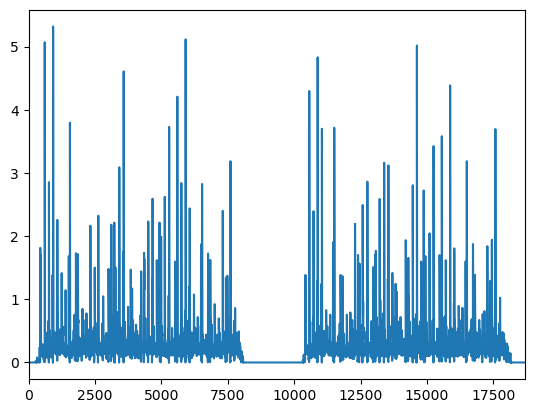

In [8]:
import matplotlib.pyplot as plt

hop_length = 100
onset_env = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

In [10]:
onset_samples = librosa.onset.onset_detect(y=x,
                                           sr=sr, units='samples',
                                           hop_length=hop_length,
                                           backtrack=True,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

onset_samples

array([  43500,   60300,   76100,   91800,  107900,  124100,  150400,
        155100,  177200,  184500,  231600,  247600,  262000,  300400,
        310800,  322200,  326200,  341000,  357800,  384300,  423200,
        433800,  449900,  466400,  482300,  492100,  494300,  497800,
        511500,  528700,  551400,  559300,  574800,  590800,  606300,
        648600,  652700,  675000,  683300,  730500,  760000, 1041900,
       1056200, 1072700, 1088100, 1104200, 1145600, 1150300, 1228300,
       1239900, 1244600, 1257500, 1274900, 1296900, 1306900, 1321600,
       1338600, 1354200, 1369200, 1419500, 1429000, 1446400, 1461900,
       1478100, 1487000, 1492600, 1508800, 1524500, 1547200, 1555200,
       1570600, 1586800, 1602600, 1644100, 1649100, 1672700, 1726600,
       1744000, 1757400])

In [11]:
onset_frames = librosa.onset.onset_detect(y=x, sr=sr, units='frames',
                                         hop_length=hop_length,
                                           backtrack=True,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)
onset_frames # frame numbers of estimated onsets

array([  435,   603,   761,   918,  1079,  1241,  1504,  1551,  1772,
        1845,  2316,  2476,  2620,  3004,  3108,  3222,  3262,  3410,
        3578,  3843,  4232,  4338,  4499,  4664,  4823,  4921,  4943,
        4978,  5115,  5287,  5514,  5593,  5748,  5908,  6063,  6486,
        6527,  6750,  6833,  7305,  7600, 10419, 10562, 10727, 10881,
       11042, 11456, 11503, 12283, 12399, 12446, 12575, 12749, 12969,
       13069, 13216, 13386, 13542, 13692, 14195, 14290, 14464, 14619,
       14781, 14870, 14926, 15088, 15245, 15472, 15552, 15706, 15868,
       16026, 16441, 16491, 16727, 17266, 17440, 17574])

In [12]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)

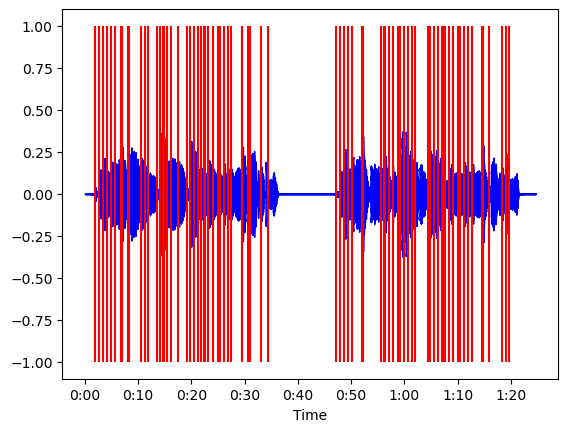

In [13]:
librosa.display.waveshow(x, sr=sr, color="blue")
plt.vlines(onset_times, -1, 1, color='r')

# Predict Note

For each part where there is a note, predict what it is and turn into MIDI note

In [14]:
# Extract MFCC features
mfcc_features = mfcc(y=x, sr=sr, hop_length=hop_length)

# splice mfcc based on onset
onset_to_predict = []

for onset in onset_frames:
    onset_to_predict.append(mfcc_features[:,onset:onset+15])
    
degrees = []
    
for onset_mfcc in onset_to_predict:
    scores=[]
    for item in hmm_models:
        hmm_model, label = item

        score = hmm_model.get_score(onset_mfcc)
        scores.append(score)
    index=np.array(scores).argmax()
    print("Predicted:", hmm_models[index][1])
    degrees.append(hmm_models[index][1])

Predicted: 60
Predicted: 67
Predicted: 60
Predicted: 71
Predicted: 60
Predicted: 69
Predicted: 61
Predicted: 63
Predicted: 70
Predicted: 63
Predicted: 60
Predicted: 61
Predicted: 71
Predicted: 69
Predicted: 65
Predicted: 63
Predicted: 66
Predicted: 60
Predicted: 60
Predicted: 61
Predicted: 67
Predicted: 60
Predicted: 69
Predicted: 60
Predicted: 63
Predicted: 60
Predicted: 70
Predicted: 65
Predicted: 60
Predicted: 60
Predicted: 67
Predicted: 67
Predicted: 60
Predicted: 63
Predicted: 66
Predicted: 67
Predicted: 60
Predicted: 61
Predicted: 63
Predicted: 63
Predicted: 70
Predicted: 67
Predicted: 67
Predicted: 60
Predicted: 67
Predicted: 63
Predicted: 67
Predicted: 60
Predicted: 60
Predicted: 61
Predicted: 60
Predicted: 63
Predicted: 61
Predicted: 69
Predicted: 63
Predicted: 61
Predicted: 63
Predicted: 60
Predicted: 63
Predicted: 70
Predicted: 63
Predicted: 60
Predicted: 61
Predicted: 63
Predicted: 60
Predicted: 60
Predicted: 61
Predicted: 60
Predicted: 70
Predicted: 65
Predicted: 60
Predic

In [23]:
# to convert notes to midi file

from midiutil import MIDIFile
import datetime

track    = 0
channel  = 0
time     = 0   # In beats
duration = 1   # In beats
tempo    = 100  # In BPM
volume   = 100 # 0-127, as per the MIDI standard

MyMIDI = MIDIFile(1) # One track, defaults to format 1 (tempo track
                     # automatically created)
MyMIDI.addTempo(track,time, tempo)

for pitch in degrees:
    MyMIDI.addNote(track, channel, pitch, time, duration, volume)
    time = time + 1

with open("export-midi/" + predict_audio + ".mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

In [24]:
# convert into sheet music

from music21 import converter, stream

midi_file_path = "export-midi/en042a.mid"
midi_stream = converter.parse(midi_file_path)

score = stream.Score()
for part in midi_stream.parts:
    score.insert(0, part)

ly_file_path = "lilypond-export/sheet_music.ly"
score.write('lilypond', ly_file_path)

import subprocess
output_file_name = "sheet-music-export/sheet_music_" + predict_audio
subprocess.run(['lilypond', '--pdf', '-o', output_file_name, ly_file_path])  # Convert to PDF

Changing working directory to: `sheet-music-export'
Processing `lilypond-export/sheet_music.ly'
Parsing...
/Users/musyaffaq/Documents/GitHub/converting-acapella-songs-to-sheet-music LOCAL/lilypond-export/sheet_music.ly:126:5: error: unknown escaped string: `\RemoveEmptyStaffContext'
    
    \RemoveEmptyStaffContext
/Users/musyaffaq/Documents/GitHub/converting-acapella-songs-to-sheet-music LOCAL/lilypond-export/sheet_music.ly:127:5: error: syntax error, unexpected \override, expecting '='
    
    \override VerticalAxisGroup #'remove-first = ##t
/Users/musyaffaq/Documents/GitHub/converting-acapella-songs-to-sheet-music LOCAL/lilypond-export/sheet_music.ly:127:33: warning: deprecated: missing `.' in property path VerticalAxisGroup.remove-first
    \override VerticalAxisGroup 
                                #'remove-first = ##t
/Users/musyaffaq/Documents/GitHub/converting-acapella-songs-to-sheet-music LOCAL/lilypond-export/sheet_music.ly:129:2: error: syntax error, unexpected '}'
 
 }
/

CompletedProcess(args=['lilypond', '--pdf', '-o', 'sheet-music-export/sheet_music_en042a', 'lilypond-export/sheet_music.ly'], returncode=1)

# Model Evaluation

In [25]:
total_dict = {}

correct_dict = {} # e.g. for pitch 61: actual pitch 61, predict pitch 61

false_negative_dict = {} # e.g. for pitch 61: actual pitch 61, predict pitch 62

false_positive_dict = {} # e.g. for pitch 61: actual pitch 62, predict pitch 61 

true_negative_dict = {} # e.g. for pitch 61: actual pitch NOT 61, predict pitch NOT 61

confusion_matrix = {}

counter = 0

for dirname in os.listdir('data/CSD/english/wav-test'):
    if dirname != ".DS_Store":
        audio_name = dirname[:dirname.rfind('.wav')]

        print("Testing the models on the audio - " + audio_name + " - audio #" + str(counter+1))
        counter += 1

        csv_file_df = pd.read_csv('data/CSD/english/csv-test/' + audio_name + '.csv')
        x, sr = librosa.load('data/CSD/english/wav-test/' + audio_name + '.wav')

        # Extract MFCC features
        mfcc_features = mfcc(y=x, sr=sr)

        onset_to_predict = []

        # get onsets
        onset_frames = librosa.time_to_frames(csv_file_df["start"].to_numpy())
        pitch_test = csv_file_df["pitch"].to_numpy()

        for onset in onset_frames:
            onset_to_predict.append(mfcc_features[:,onset:onset+15])

        pitch_pred = []

        for onset_mfcc in onset_to_predict:
            scores=[]
            for item in hmm_models:
                hmm_model, label = item

                score = hmm_model.get_score(onset_mfcc)
                scores.append(score)
            index=np.array(scores).argmax()
            pitch_pred.append(hmm_models[index][1])

        for test, pred in zip(pitch_test, pitch_pred):
            if test not in total_dict:
                correct_dict[test] = 0
                total_dict[test] = 0
                false_negative_dict[test] = 0
                false_positive_dict[test] = 0
                true_negative_dict[test] = 0
            if pred not in total_dict:
                correct_dict[pred] = 0
                total_dict[pred] = 0
                false_negative_dict[pred] = 0
                false_positive_dict[pred] = 0
                true_negative_dict[pred] = 0
            total_dict[test] += 1
            if test == pred:
                correct_dict[test] += 1
            else:
                false_negative_dict[test] += 1
                false_positive_dict[pred] += 1
            conf_label = f"{test} - {pred}"
            if conf_label not in confusion_matrix:
                confusion_matrix[conf_label] = 0
            confusion_matrix[conf_label] += 1
            
        true_negative_dict[test] = total_dict[test] - correct_dict[test]

Testing the models on the audio - en041b - audio #1
Testing the models on the audio - en041a - audio #2
Testing the models on the audio - en047a - audio #3
Testing the models on the audio - en047b - audio #4
Testing the models on the audio - en046b - audio #5
Testing the models on the audio - en050b - audio #6
Testing the models on the audio - en046a - audio #7
Testing the models on the audio - en050a - audio #8
Testing the models on the audio - en045a - audio #9
Testing the models on the audio - en049b - audio #10
Testing the models on the audio - en045b - audio #11
Testing the models on the audio - en049a - audio #12
Testing the models on the audio - en048a - audio #13
Testing the models on the audio - en044b - audio #14
Testing the models on the audio - en048b - audio #15
Testing the models on the audio - en044a - audio #16
Testing the models on the audio - en043b - audio #17
Testing the models on the audio - en043a - audio #18
Testing the models on the audio - en042a - audio #19
Te

In [26]:
total_count = 0
total_correct = 0
total_false_negative = 0
total_false_positive = 0
total_true_negative = 0

for pitch, count in correct_dict.items():
    print(f"###### Evaluation for Pitch {pitch} ######")
    total_correct += count
    total_count += total_dict[pitch]
    total_false_negative += false_negative_dict[pitch]
    total_false_positive += false_positive_dict[pitch]
    total_true_negative += true_negative_dict[pitch]
    
    if total_dict[pitch] == 0:
        print(f"Pitch {pitch} accuracy is NaN")
    else:
        print(f"Pitch {pitch} accuracy is {(count + true_negative_dict[pitch])/total_dict[pitch]}")
    
    if (count + false_positive_dict[pitch]) == 0:
        print(f"Pitch {pitch} precision is NaN")
    else:
        print(f"Pitch {pitch} precision is {count/(count + false_positive_dict[pitch])}")
    
    if (count + false_negative_dict[pitch]) == 0:
        print(f"Pitch {pitch} recall is NaN")
    else:
        print(f"Pitch {pitch} recall is {count/(count + false_negative_dict[pitch])}")
        
    print()
    
print()
    
print(f"Overall accuracy is {(total_correct + total_true_negative)/total_count}")
print(f"Microaverage precision is {total_correct/(total_correct + total_false_positive)}")
print(f"Microaverage recall is {total_correct/(total_correct + total_false_negative)}")

###### Evaluation for Pitch 61 ######
Pitch 61 accuracy is 0.5509554140127388
Pitch 61 precision is 0.22151898734177214
Pitch 61 recall is 0.2229299363057325

###### Evaluation for Pitch 60 ######
Pitch 60 accuracy is 1.0
Pitch 60 precision is 0.08639308855291576
Pitch 60 recall is 0.28776978417266186

###### Evaluation for Pitch 65 ######
Pitch 65 accuracy is 0.4280821917808219
Pitch 65 precision is 0.1520912547528517
Pitch 65 recall is 0.273972602739726

###### Evaluation for Pitch 63 ######
Pitch 63 accuracy is 1.0
Pitch 63 precision is 0.1141732283464567
Pitch 63 recall is 0.34523809523809523

###### Evaluation for Pitch 66 ######
Pitch 66 accuracy is 0.9424460431654677
Pitch 66 precision is 0.155
Pitch 66 recall is 0.22302158273381295

###### Evaluation for Pitch 71 ######
Pitch 71 accuracy is 0.20253164556962025
Pitch 71 precision is 0.09876543209876543
Pitch 71 recall is 0.20253164556962025

###### Evaluation for Pitch 68 ######
Pitch 68 accuracy is 0.0
Pitch 68 precision is 0.0

In [27]:
for label, count in confusion_matrix.items():
    print(label, ":", count)

61 - 60 : 98
61 - 65 : 65
61 - 61 : 70
63 - 63 : 58
65 - 63 : 39
65 - 66 : 44
65 - 60 : 27
63 - 61 : 26
65 - 61 : 22
63 - 65 : 28
63 - 60 : 43
65 - 71 : 13
65 - 65 : 80
66 - 63 : 10
68 - 70 : 27
66 - 67 : 28
68 - 63 : 6
61 - 63 : 62
65 - 67 : 32
65 - 69 : 13
67 - 63 : 19
69 - 63 : 12
69 - 70 : 32
69 - 66 : 12
67 - 67 : 90
69 - 62 : 1
69 - 69 : 24
67 - 70 : 65
70 - 63 : 2
72 - 70 : 15
70 - 67 : 5
72 - 63 : 3
67 - 64 : 7
67 - 66 : 17
69 - 61 : 4
69 - 65 : 18
69 - 67 : 25
64 - 65 : 139
67 - 65 : 45
64 - 60 : 37
67 - 71 : 38
72 - 67 : 10
67 - 69 : 52
60 - 60 : 40
62 - 63 : 77
64 - 63 : 80
62 - 61 : 38
62 - 60 : 76
64 - 61 : 30
62 - 65 : 44
64 - 67 : 21
60 - 69 : 3
65 - 70 : 21
60 - 63 : 39
72 - 65 : 8
67 - 60 : 4
72 - 61 : 2
64 - 71 : 5
64 - 66 : 38
60 - 61 : 29
62 - 66 : 7
64 - 69 : 13
57 - 63 : 15
59 - 61 : 37
59 - 60 : 59
61 - 67 : 2
62 - 67 : 4
57 - 67 : 4
57 - 60 : 30
69 - 71 : 19
59 - 65 : 16
57 - 61 : 16
59 - 63 : 50
59 - 67 : 6
59 - 66 : 3
58 - 61 : 12
58 - 63 : 15
63 - 66 : 10
63 